In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import tikzplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from kneed import KneeLocator
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

[nltk_data] Downloading package stopwords to /home/richi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analizar nuestros datos
1. Importar archivo json

In [3]:
ds_jobs=pd.read_json('jobs_ds.json',encoding='utf-8')
ds_jobs.head()

,title_html,body_html,li_body,non_li_body
0,Data Science Manager Leeds - Reed.co.uk,Data Science Manager Data Science Manager Up t...,[Leading data science projects under the direc...,Data Science Manager Data Science Manager Up t...
1,Data Science Engineer London - Reed.co.uk,Data Science Engineer Data Science Engineer LO...,[5 Years' experience implementing within Data ...,Data Science Engineer Data Science Engineer LO...
2,Head of Data Science London - Reed.co.uk,Head of Data Science Head of Data ScienceLondo...,[Manage a small team of 3 Data Scientists incl...,Head of Data Science Head of Data ScienceLondo...
3,Python Quantitative Researcher - London- Globa...,Python Quantitative Researcher - London- Globa...,"[Minimum 2+ years' experience, Hands-on progra...",Python Quantitative Researcher - London- Globa...
4,Engineering Lead London - Reed.co.uk,Engineering Lead Engineering Manager | Fin-Tec...,[Lead/manage a diverse team of up to 30+ engin...,Engineering Lead Engineering Manager | Fin-Tec...


2. Eliminar páginas no encontradas

In [5]:
ds_page_non=ds_jobs[ds_jobs["title_html"].str.contains(r'page no',case=False)==True] 
ds_page_non

,title_html,body_html,li_body,non_li_body
3337,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3451,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3561,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3562,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3867,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3890,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3950,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone
3953,Page non trouvée | ITjobs.ca,NoneNone,[],NoneNone


In [6]:
# exportar datafrmae a tabla en formato tex 
print(ds_page_non.to_latex())

\begin{tabular}{lllll}
\toprule
{} &                    title\_html & body\_html & li\_body & non\_li\_body \\
\midrule
3337 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3451 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3561 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3562 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3867 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3890 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3950 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
3953 &  Page non trouvée | ITjobs.ca &  NoneNone &      [] &    NoneNone \\
\bottomrule
\end{tabular}



Se puede ver que hay 8 ofertas de empleo no encontradas. Estas filas no aportan nada y por lo tanto serán eliminadas.

In [7]:
ds_jobs = ds_jobs[ds_jobs["title_html"].str.contains('Page no') == False] 
ds_jobs.shape

(4300, 4)

3. Mostrar estadística descriptiva

In [9]:
ds_jobs[['title_html','body_html']].describe()
#print(ds_jobs[['title_html','body_html']].describe().to_latex())

,title_html,body_html
count,4300,4300
unique,3888,3929
top,"Database Administrator, Oracle EBS Job in Edmo...",Product Specialist Description JOB SUMMARYThe...
freq,9,23


3889 de los 4308 títulos (title_html) son únicos, los 419 títulos restantes son duplicados. El título más común se repite 9 veces: es para un puesto de **Analista funcional**. Por otro lado, 3929 cuerpos (body_html) son únicos, por lo que 379 son duplicados. Por lo tanto, debemos eleiminar los duplicados de la columna **body_html** aunque algunas ofertas compartan un título genérico común.

4. Eliminar cuerpos duplicados (body_html). Estos duplicados se debe a que existe un mismo anuncio para diferentes ciudades.

In [10]:
#pd.options.display.max_colwidth=100
ds_jobs.drop_duplicates(subset=['body_html'],inplace=True)

In [11]:
ds_jobs=ds_jobs.reset_index(drop=True)
ds_jobs.shape

(3929, 4)

Las viñetas de cada oferta de empleo se almacenan en ds_jobs.['li_body']. Sin embargo, es posible que algunos (o la mayoría) de los anuncios no incluyan viñetas. ¿Qué porcentaje de ofertas de empleo contienen realmente texto con viñetas? Tenemos que averiguarlo. Si ese porcentaje es demasiado bajo, no merece la pena seguir analizando las viñetas. Midamos el porcentaje.

4. Medir el porcentaje de publicaciones con viñetas

In [10]:
li_count = 0
for li in ds_jobs.li_body:
    if li:
        li_count += 1

percent_li = 100 * li_count / ds_jobs.shape[0]
print(f"{percent_li:.2f}% de los anuncios contienen viñetas")

77.76% de los anuncios contienen viñetas


El 77.76% de las ofertas de empleo contienen viñetas. ¿Todas (o la mayoría) de estas viñetas se centran en las competencias? Actualmente no lo sabemos. Sin embargo, podemos calibrar mejor el contenido de las viñetas imprimiendo las palabras mejor clasificadas en su texto. Podemos clasificar estas palabras por el número de apariciones; alternativamente, podemos llevar a cabo la clasificación utilizando valores de término frecuencia - frecuencia inversa de documento (TFIDF) en lugar de recuentos brutos. 

A continuación, clasificamos las palabras utilizando los valores TFIDF sumados. Primero calculamos una matriz TFIDF en la que las filas corresponden a las viñetas individuales. A continuación, sumamos las filas de la matriz: estas sumas se utilizan para clasificar las palabras, que corresponden a las columnas de la matriz. Por último, comprobamos si las cinco palabras mejor clasificadas contienen terminología relacionada con las competencias.

5. Examinar las palabras mejor clasificadas en las viñetas HTML

In [14]:
def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    #df = pd.DataFrame({'Palabras': vectorizer.get_feature_names_out(),
    df = pd.DataFrame({'Palabras': vectorizer.get_feature_names(),
                       'Suma TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Suma TFIDF', ascending=False)
    return sorted_df

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
def rank_words(text_list):
```
Devuelve una tabla Pandas ordenada con las palabras mejor clasificadas

```python
df = pd.DataFrame({'Palabras': vectorizer.get_feature_names(),
                   'Suma TFIDF': tfidf_matrix.sum(axis=0)})
```

Las palabras se ordenan según la suma de los valores TFIDF de las filas de tfidf_matrix.

In [15]:
all_li = []
for li_list in ds_jobs.li_body:
    all_li.extend(li_list)
sorted_df = rank_words(all_li)
print(sorted_df[:5].to_string(index=False))

   Palabras   Suma TFIDF
 experience  1958.677833
       data  1757.298992
     skills  1044.849553
       work   992.226009
    science   893.043257


Términos como competencias (skills) y experiencia (experience) aparecen entre las cinco palabras con más viñetas. Hay indicios razonables de que las viñetas corresponden a competencias laborales concretas. 

¿Cómo se comparan las palabras de las viñetas con el resto de palabras de cada oferta de empleo? Averigüémoslo aplicando la función **rank_words** a la columna **non_li_body** y mostramos las cinco palabras sin viñetas más importantes.

6. Examinar las palabras mejor clasificadas en los cuerpos HTML

In [16]:
sorted_df = rank_words(ds_jobs.non_li_body)
print(sorted_df[:5].to_string(index=False))

   Palabras  Suma TFIDF
       data  246.002726
       team  122.704533
 experience  116.499467
       work  110.406079
    science  108.221937


Las palabras competencias (skills) ya no están presentes en la clasificación. Han sido sustituidas por las palabras equipo (team). Así, el texto sin viñetas parece menos orientado a las competencias que el contenido de las viñetas. Sin embargo, es interesante observar que algunas de las palabras mejor clasificadas comparten las viñetas y las no viñetas: datos (data), experiencia (experience), ciencia (science) y trabajo (work). ¿Es posible que algunas entradas se refieran a trabajos relacionados con los datos que no son directamente trabajos relacionados con la ciencia de los datos? 

7. Comprobar títulos que hacen referencia a puestos de ciencia de datos

In [17]:
regex = r'Data Scien(ce|tist)'
text_non_ds = ds_jobs[~ds_jobs.title_html.str.contains(regex, case=False)]
text_non_ds.reset_index(drop=True).head()

,title_html,body_html,li_body,non_li_body
0,Python Quantitative Researcher - London- Globa...,Python Quantitative Researcher - London- Globa...,"[Minimum 2+ years' experience, Hands-on progra...",Python Quantitative Researcher - London- Globa...
1,Engineering Lead London - Reed.co.uk,Engineering Lead Engineering Manager | Fin-Tec...,[Lead/manage a diverse team of up to 30+ engin...,Engineering Lead Engineering Manager | Fin-Tec...
2,Quality Manager Stonehouse - Reed.co.uk,Quality Manager Quality Manager Stonehouse Com...,[Manage documents and data for Cost of Quality...,Quality Manager Quality Manager Stonehouse Com...
3,Head of IT London - Reed.co.uk,Head of IT Robert Half are currently engaged b...,[Grow and execute the Banks IT strategy in ali...,Head of IT Robert Half are currently engaged b...
4,Application Support Consultant Brighton - Ree...,Application Support Consultant Position: App...,"[Position: Application Support Consultant, Sal...",Application Support Consultant We are looki...


<h4 style='color:purple'>¿Comó funciona?</h4>

```python
str.contains(regex, case=False)
```
el método de Pandas **str.contains** puede hacer coincidir una expresión regular con el texto de la columna. Si se pasa **case=False**, la coincidencia no distingue entre mayúsculas y minúsculas.

In [15]:
percent_non_ds = 100 * text_non_ds.shape[0] / ds_jobs.shape[0]
print(f"{percent_non_ds:.2f}% de los títulos de las ofertas de empleo no mencionan un "
"puesto en ciencia de datos.")

75.95% de los títulos de las ofertas de empleo no mencionan un puesto en ciencia de datos.


A continuación se ofrece una muestra de dichos títulos:

In [16]:
def show_titles(df,a,b):
    for title in df.title_html[a:b]:
        print(title)     

In [17]:
show_titles(text_non_ds,0,10)

Python Quantitative Researcher - London- Global Quant Firm London - Reed.co.uk
Engineering Lead London - Reed.co.uk
Quality Manager Stonehouse - Reed.co.uk
Head of IT London - Reed.co.uk
Application Support Consultant  Brighton - Reed.co.uk
Research Director - Corporate Reputation London - Reed.co.uk
Software Developer Ashton-under-Lyne - Reed.co.uk
Software Developer Node.js Neo4j London - Reed.co.uk
Software Engineer - C++ London - Reed.co.uk
Data Governance Scrum Master London - Reed.co.uk


In [51]:
#print(text_non_ds.title_html.iloc[:10].to_string(index=False))

El 75.95\% de los títulos de los anuncios no mencionan un puesto de ciencia de datos. Sin embargo, a partir de nuestra muestra de resultados, podemos deducir el lenguaje alternativo que se puede utilizar para describir un puesto de ciencia de datos. Puede tratarse de un especialista en datos, un analista de datos o un programador científico. Además, algunas ofertas de empleo son para Ingeniero/Desarrollador de software, por lo que podemos suponer que se centran en los datos. Pero no todos los empleos de la muestra son totalmente relevantes: varios anuncios son para puestos de gestión, que no se ajustan a nuestros objetivos profesionales inmediatos. La gestión es una carrera distinta que requiere su propio conjunto de competencias. Deberíamos considerar la posibilidad de excluir los puestos directivos de nuestro análisis.

Y lo que es más preocupante, el tercer puesto de la lista es para \textbf{Respondable de calidad}. El anuncio contiene competencias de las que carecemos y que tampoco nos interesa obtener. Estas competencias irrelevantes suponen un peligro para nuestro análisis y servirán como fuente de ruido si no se eliminan. Podemos ilustrar este peligro imprimiendo las cinco primeras viñetas de text_non_ds[2].

8. Viñetas que muestran de un trabajo no relacionado con la ciencia de datos

In [18]:
print(pd.DataFrame(text_non_ds['li_body'].iloc[2][0:5],columns=['li_non_ds']).to_latex())
pd.DataFrame(text_non_ds['li_body'].iloc[2][0:5],columns=['li_non_ds'])

\begin{tabular}{ll}
\toprule
{} &                                          li\_non\_ds \\
\midrule
0 &  Manage documents and data for Cost of Quality ... \\
1 &  Report the continuous improvement progress and... \\
2 &  Manage metrics, records, and reports; includes... \\
3 &  Uses international standards as well as intern... \\
4 &  Support senior leadership team with ad hoc ana... \\
\bottomrule
\end{tabular}



,li_non_ds
0,Manage documents and data for Cost of Quality ...
1,Report the continuous improvement progress and...
2,"Manage metrics, records, and reports; includes..."
3,Uses international standards as well as intern...
4,Support senior leadership team with ad hoc ana...


Somos científicos de datos; nuestro objetivo principal no es Gestionar documentos (índice 0) ni Apoyo al equipo directivo (índice 4). Tenemos que eliminar estas competencias de nuestro conjunto de datos, pero ¿cómo? Un método consiste en utilizar la similitud textual. Podríamos comparar los anuncios con nuestra tabla de contenidos del curso y eliminar los puestos que no coincidan con nuestra tabla de contenidos. Básicamente, deberíamos evaluar la relevancia de cada empleo en relación con la tabla de contenidos del curso; esto nos permitiría filtrar los anuncios superfluos y conservar sólo los empleos más relevantes.

Otra posibilidad sería filtrar las competencias individuales contenidas en las viñetas. Básicamente, clasificaríamos los puntos individuales en lugar de los puestos individuales. Pero este segundo enfoque plantea un problema. Imaginemos que filtramos todas las viñetas que no se ajustan a nuestra tabla de contenidos del curso: las viñetas que quedan abarcarán habilidades que ya poseemos. Esto va en contra de nuestro objetivo de descubrir las habilidades que nos faltan a través de los anuncios de ciencia de datos relevantes. En su lugar, deberíamos lograr nuestro objetivo de la siguiente manera:

1. Obtener ofertas de empleo relevantes que se ajusten parcialmente a nuestro conjunto de competencias actuales.

2. Examinar qué puntos de estos anuncios faltan en nuestro actual conjunto de competencias.

Con esta estrategia en mente, ahora filtraremos los trabajos por relevancia.

# 2. Filtrar empleos por relevancia

Nuestro objetivo es evaluar la relevancia de un empleo utilizando la similitud textual. Queremos comparar el texto de cada anuncio con la tabla de contenidos de nuestro curso. Para prepararnos, almacenemos nuestra tabla de contenidos en una cadena llamada **index**.

1. Cargar el índice del curso

In [18]:
skills = open('index.txt', 'r').read()

Nuestra tarea consiste en calcular la similitud textual entre cada oferta de empleo y nuestras competencias alcanzadas. En otras palabras, queremos calcular todas las similitudes entre **ds_jobs.body_html** y **skills**. Para ello, primero tenemos que vectorizar todos los textos. Tenemos que vectorizar **df_jobs.body_html** junto con **skills** para asegurarnos de que todos los vectores comparten el mismo vocabulario. A continuación, combinamos nuestras ofertas de empleo y nuestra cadena de habilidades en una sola lista de textos y vectorizamos estos textos utilizando la implementación **Tfidf-Vectorizer** de scikit-learn.

2. Vectorizar nuestras competencias y los datos de ofertas de empleo.

In [19]:
text_list = ds_jobs.body_html.values.tolist() + [skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

La última fila de la matriz ( tfidf_matrix[-1] ) corresponde a nuestro conjunto de competencias existentes, y todas las demás filas de (tfidf_matrix[:-1]) corresponden a las ofertas de empleo. Así, podemos calcular fácilmente las similitudes del coseno entre las ofertas de empleo y existing_skills . Basta con ejecutar tfdf_matrix[:-1] @ tfidf_matrix[-1] : este producto matriz-vector devuelve una matriz de similitudes coseno. 

3. Calcular las similitudes coseno basadas en las competencias

In [20]:
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]

Las similitudes del coseno reflejan el solapamiento textual entre nuestras competencias y los empleos publicados. Los empleos con mayor solapamiento son más relevantes, y los empleos con menor solapamiento son menos relevantes. Por lo tanto, podemos utilizar las similitudes del coseno para clasificar los empleos según su relevancia. Llevemos a cabo la clasificación. En primer lugar, debemos almacenar las similitudes del coseno en una columna **relevancy** de **ds_jobs**. A continuación, ordenamos la tabla por **ds_jobs.relevancy** en orden descendente. Por último, imprimimos los 20 empleos menos relevantes de la tabla ordenada y confirmamos si estos empleos tienen algo que ver con la ciencia de datos.

4. Crear la columna **relevancy**

In [21]:
ds_jobs['relevancy'] = cosine_similarities
sorted_ds_jobs = ds_jobs.sort_values('relevancy', ascending=False)

In [22]:
sorted_ds_jobs.head()

,title_html,body_html,li_body,non_li_body,relevancy
1922,Amazon.com Services LLC - Data Science Manager...,Data Science ManagerDescriptionOperations Tech...,[],Data Science ManagerDescriptionOperations Tech...,0.219130
719,Junior Data Scientist Manchester - Reed.co.uk,Junior Data Scientist Title: Junior Data Scien...,"[Collect, clean, and preprocess data to make i...",Junior Data Scientist Title: Junior Data Scien...,0.177863
653,Data Scientist East London - Reed.co.uk,Data Scientist JD For Data Scientist Responsib...,[4+ years of relevant experience specialized i...,Data Scientist JD For Data Scientist Responsib...,0.177429
2263,Middlebury College - Data Services Librarian j...,Data Services LibrarianJob DescriptionThe Data...,[Develop strong working relationships with fac...,Data Services LibrarianJob DescriptionThe Data...,0.174417
2106,Affinity - Data Scientist job in Cleveland OH ...,Data ScientistDescriptionThe primary focus wil...,[Lead discovery processes with business stakeh...,Data ScientistDescriptionThe primary focus wil...,0.152593


In [212]:
print(sorted_ds_jobs.head().to_latex())

\begin{tabular}{lllllr}
\toprule
{} &                                         title\_html &                                          body\_html &                                            li\_body &                                        non\_li\_body &  relevancy \\
\midrule
1922 &  Amazon.com Services LLC - Data Science Manager... &  Data Science ManagerDescriptionOperations Tech... &                                                 [] &  Data Science ManagerDescriptionOperations Tech... &   0.219130 \\
719  &      Junior Data Scientist Manchester - Reed.co.uk &  Junior Data Scientist Title: Junior Data Scien... &  [Collect, clean, and preprocess data to make i... &  Junior Data Scientist Title: Junior Data Scien... &   0.177863 \\
653  &            Data Scientist East London - Reed.co.uk &  Data Scientist JD For Data Scientist Responsib... &  [4+ years of relevant experience specialized i... &  Data Scientist JD For Data Scientist Responsib... &   0.177429 \\
2263 &  Middlebury Coll

In [17]:
#sorted_ds_jobs.to_json('sorted_ds_jobs.json')

* Mostrar los 20 trabajos menos relevantes

In [25]:
show_titles(sorted_ds_jobs,a=-20, b=-1)

1st Line Support Engineer Luton - Reed.co.uk
IT Technician Job in Montreal for DELAN - IT Head Hunters | ITjobs.ca
Network Architect - Trading London - Reed.co.uk
Senior Recruitment Consultant - IT and Technology London - Reed.co.uk
Head of Cyber Security London - Reed.co.uk
Network Integrator (6+ month contract) Job in Montreal for DELAN - IT Head Hunters | ITjobs.ca
Medical Devices - Senior Mechanical Design Engineer - Cambridge Cambridge - Reed.co.uk
Technical Product Development Chemist        South East England - Reed.co.uk
Chemistry Graduate Bridgend - Reed.co.uk
Publicis Groupe - Publicis Media - Duales BA-Studium Wirtschaftsinformatik Dat... job | Jobcube
Graduate Geoenvironmental Consultant North Yorkshire - Reed.co.uk
R&D Tax Analyst London - Reed.co.uk
Food Lead Warrington - Reed.co.uk
Accounts Administrator Buckley - Reed.co.uk
Manager, Systems Support and Maintenance Job in Burnaby for City of Burnaby | ITjobs.ca
Bilingual IT Service Technician / Technicien(ienne) bilingue

La mayoría de los empleos impresos son completamente irrelevantes. Entre las diversas oportunidades de empleo irrelevantes figuran: Ingeniero Soporte, Jefe de Ciberseguridad, Licenciado en Química, etc. En uno de los títulos de empleo se lee incluso Page Not Found, lo que indica que la página web no se ha descargado correctamente. Podemos descartar los 20 empleos peor clasificados de la tabla. Ahora, para comparar, imprimamos los 20 puestos más relevantes en sorted_ds_jobs .

5. Mostrar los 20 trabajos más relevantes

In [26]:
#sorted_ds_jobs.to_json('sorted_df.json')

In [27]:
show_titles(sorted_ds_jobs,a=0,b=20)

Amazon.com Services LLC - Data Science Manager job in Austin TX | Jobcube
Junior Data Scientist Manchester - Reed.co.uk
Data Scientist East London - Reed.co.uk
Middlebury College - Data Services Librarian job in Middlebury VT | Jobcube
Affinity - Data Scientist job in Cleveland OH | Jobcube
Data Scientist job in Joplin MO | Jobcube
Arrow Electronics - Senior Machine Learning Engineer job | Jobcube
Biogen - Sr. Manager, Data Scientist job in Durham NC | Jobcube
Invictus International Consulting - Data Scientist job in Fort Meade MD | Jobcube
Senior Data Scientist Colchester - Reed.co.uk
Sourcefuse Inc - Senior Machine Learning Engineer job | Jobcube
Axtria, Inc - Senior Data Scientist - AI/ML Modeler job in Berkeley Heights NJ | Jobcube
Data Scientist Chester - Reed.co.uk
Epiq - Senior Software Engineer job | Jobcube
CNET Global Solutions Inc - AI/ML Architect job in Irving TX | Jobcube
Herc - Norcal - Mathematics, Statistics, and Computational Sciences Libraria... job in Stanford CA | 

Casi todos los puestos impresos corresponden a la ciencia de datos. Algunos ofertas probablemente estén más allá de nuestro nivel de competencias alcanzadas hasta ahora, pero las ofertas mejor clasificadas parecen ser bastante relevantes para nuestra carrera en la ciencia de datos.

Claramente, cuando df_jobs.relevancy es alto, las ofertas de empleo asociadas son relevantes. A medida que df_jobs.relevancy disminuye, los empleos asociados pierden relevancia. Por lo tanto, podemos suponer que existe un límite en df_jobs.relevancy que separa las ofertas relevantes de las que no lo son. Intentemos identificar ese límite. Empezaremos visualizando la forma de la distribución de relevancia ordenada en relación con el rango. En otras palabras, trazamos range(df_jobs.shape[0]) frente a sorted_df_jobs.relevancy. En el gráfico, se puede ver una curva de relevancia que disminuye continuamente; cualquier disminución repentina de la relevancia en la curva indica una separación entre trabajos relevantes y no relevantes.

6. Graficar los puestos de trabajo en función de su relevancia

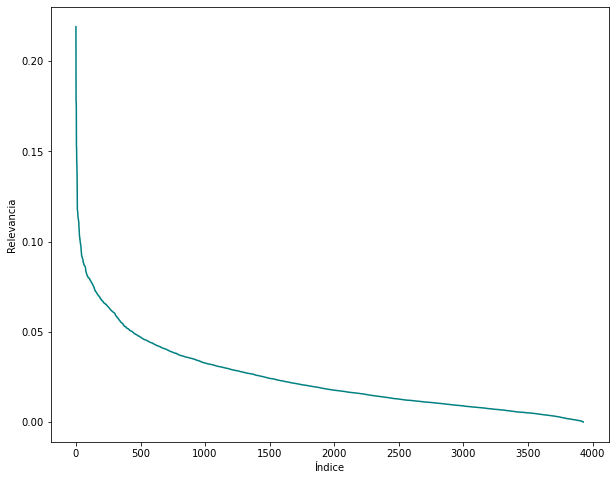

In [24]:
plt.figure(figsize=(10,8))
plt.plot(range(ds_jobs.shape[0]), sorted_ds_jobs.relevancy.values,c='teal')
plt.xlabel('Índice')
plt.ylabel('Relevancia')
plt.show()

Figura 3. Clasificación de los índices de ofertas de empleo en función de la relevancia. Los índices más bajos indican una mayor relevancia. La relevancia es igual a la similitud coseno entre cada empleo y **skills**. 

Nuestra curva de relevancia se asemeja a un gráfico de codo K-means. Por lo tanto, nos apoyaremos en el método **kneeLocator** para encontrar el punto de inflexión de la curva. finalmente trazaremos una línea vertical en dicho punto de nuestro gráfico (figura 4).

In [216]:
klocator_relevance = KneeLocator(range(ds_jobs.shape[0]), 
                                 sorted_ds_jobs.relevancy.values,
                                 curve="convex", direction="decreasing")
print(f'k_relevance={klocator_relevance.elbow}')

k_relevance=98


7. Añadir un corte al gráfico de relevancia

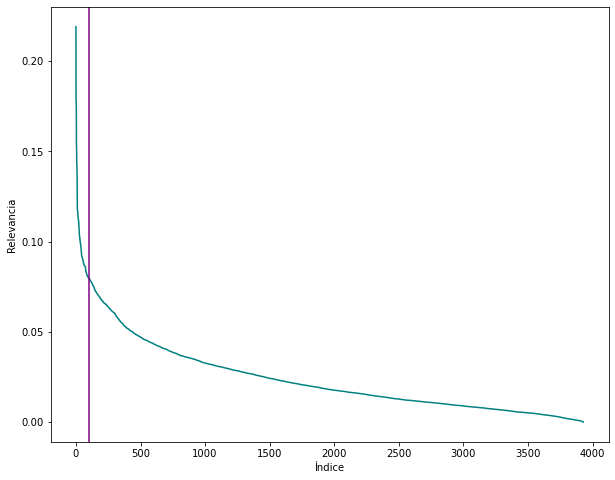

In [25]:
plt.figure(figsize=(10,8))
plt.plot(range(ds_jobs.shape[0]), sorted_ds_jobs.relevancy.values,c='teal')
plt.xlabel('Índice')
plt.ylabel('Relevancia')
plt.axvline(98, c='purple')
#tikzplotlib.save("fig07.tex")
plt.show()

Figura 4. Índices de ofertas de empleo ordenadas en función de la relevancia. En el gráfico también se incluye una línea vertical en 98. Los índices inferiores a 98 corresponden a valores de relevancia mucho más elevados.

De nuestro gráfico se desprende que los primeros 98 empleos son notablemente más relevantes que todos los siguientes. Vamos a comprobarlo. Como ya hemos visto, las primeras 20 tareas son muy relevantes. Según nuestra hipótesis, los trabajos del 78 al 98 también deberían ser muy relevantes. A continuación, imprimimos sorted_ds_jobs[78: 98].title_html con fines de evaluación.

8. Mostrar títulos de trabajos por debajo del corte de relevancia

In [218]:
show_titles(sorted_ds_jobs,a=78,b=98)

Payment Platform/program End to End Test Lead, Automation Testing Job in Toronto for BMO | ITjobs.ca
Praisidio - Machine Learning Engineer job in San Francisco CA | Jobcube
The Walt Disney Company - Data Scientist II job in Santa Monica CA | Jobcube
PaxeraHealth - Data Science Developer job | Jobcube
AI Scientific Software Developer Leeds - Reed.co.uk
Walmart, Inc - 2024 Summer Intern: Walmart Connect, Data Science job in Hoboken NJ | Jobcube
Digital Technology Solutions - Data Scientist job in Lewisville TX | Jobcube
CIDIS LLC - Diversity and Inclusion Workforce Data Scientist job in Springfield VA | Jobcube
Peraton - Senior Data Scientist / ORSA job in Fort Meade MD | Jobcube
Rockwell Automation - Senior Data Scientist job in Mayfield Heights OH | Jobcube
Data Science Manager Leeds - Reed.co.uk
Target - Current Interns Only- Sr. Data Scientist-Summer 2023 Intern ... job in Minneapolis MN | Jobcube
Gridiron IT Solutions - Data Scientist job in Fort Belvoir VA | Jobcube
Amazon Kuiper M

Casi todas las ofertas impresas son para puestos de científico/analista de datos. El único caso atípico es el de un Jefe de plataformas/programa de pagos. A pesar de ello, el resto de los puestos son muy relevantes.

9. Mostrar títulos de trabajos más allá del corte de relevancia

In [219]:
show_titles(sorted_ds_jobs,a=98,b=118)

Jacobs - Data Scientist Lead job in FL | Jobcube
Junior Data Scientist Sale - Reed.co.uk
IQVIA - Associate Data Science Director job in PA | Jobcube
Peraton - ORSA / Data Scientist job in Fort Meade MD | Jobcube
Capital One - Senior Associate, Data Science - Financial Services job in Plano TX | Jobcube
Data Scientist Ml/Dl/NLP/Llm, ICC AI Center of Excellence Job in Vancouver for Amazon | ITjobs.ca
Lead Data Scientist Job in Toronto for Equifax | ITjobs.ca
Peraton - Mid-Level ORSA / Data Scientist job in Fort Meade MD | Jobcube
Walmart, Inc - Staff Data Scientist - Marketing Decision Science job in Sunnyvale CA | Jobcube
Delta Air Lines - Graduate Intern, Data Scientist (Summer, 2024) job in Atlanta GA | Jobcube
Delta Air Lines - Graduate Intern, Data Scientist (Spring, 2024) job in Atlanta GA | Jobcube
Jobot - Senior Data Scientist (LLM / Transformer) job in Austin TX | Jobcube
Amazon.com Services LLC - Amazon Robotics - Data Scientist Co-Op - Fall 2023 (July - D... job in North Readi

Algunos de los títulos de los puestos 98 a 118 siguen siendo relevantes. Algunos puestos son de gestión y otro incluso de Desarrollador de Python de nivel básico. No obstante, la mayoría de los puestos se refieren a funciones de analista/científico de datos. Podemos cuantificar rápidamente esta observación utilizando expresiones regulares. Definimos una función **percent_relevant_titles**, que devuelve el porcentaje de puestos de análisis y ciencia de datos no relacionados con la gestión.

10. Medir la relevancia del título en un subconjunto de trabajos

In [26]:
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)',flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)',flags=re.IGNORECASE)
    match_count = len([title for title in df.title_html
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
 re.compile(r'Data (Scien|Analy)',flags=re.IGNORECASE)
```
Busca ofertas de empleo relevantes que mencionen puestos de analista/científico de datos.

```python
 re.compile(r'\b(Manage)',flags=re.IGNORECASE)
```
Busca ofertas de empleo irrelevantes que mencionan cargos directivos.

```python
  match_count = len([title for title in df.Title
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
```
Cuenta el número de coincidencias de títulos de analistas/científicos de datos no relacionados con la gestión.

In [221]:
percent = percent_relevant_titles(sorted_ds_jobs[98: 118])
print(f"Aproximadamente el {percent:.2f}% de los puestos de trabajo entre los índices "
       "98 - 1118 son relevantes")

Aproximadamente el 90.00% de los puestos de trabajo entre los índices 98 - 1118 son relevantes


Aproximadamente 90% de los puestos de sorted_ds_jobs[98:118] son relevantes. Aunque la relevancia de los empleos ha disminuido más allá del índice 98, más del 50% de los títulos siguen refiriéndose a empleos en ciencia de datos. Tal vez ese porcentaje disminuya si tomamos una muestra de los 20 empleos siguientes en un intervalo de índices de 118 a 138. Comprobémoslo.

11. Medir la relevancia del título en el siguiente subconjunto de trabajos

In [222]:
percent = percent_relevant_titles(sorted_ds_jobs[118: 138])
print(f"Aproximadamente el {percent:.2f}% de los puestos de trabajo entre los índices "
       "118 - 138 son relevantes")

Aproximadamente el 70.00% de los puestos de trabajo entre los índices 118 - 138 son relevantes


El porcentaje de títulos de ciencias de datos ha bajado al 70%. ¿En qué momento caerá el porcentaje por debajo del 50%? ¡Podemos averiguarlo fácilmente! Vamos a iterar sobre sorted_ds_jobs[i: i + 20] para todos los valores de i . En cada iteración, calculamos el porcentaje de relevancia. A continuación, trazamos todos los porcentajes (figura 5). También trazamos una línea horizontal al 50% para poder determinar el índice en el que los puestos relevantes son minoritarios.

12. Graficar el porcentaje de relevancia de todas las muestras de títulos

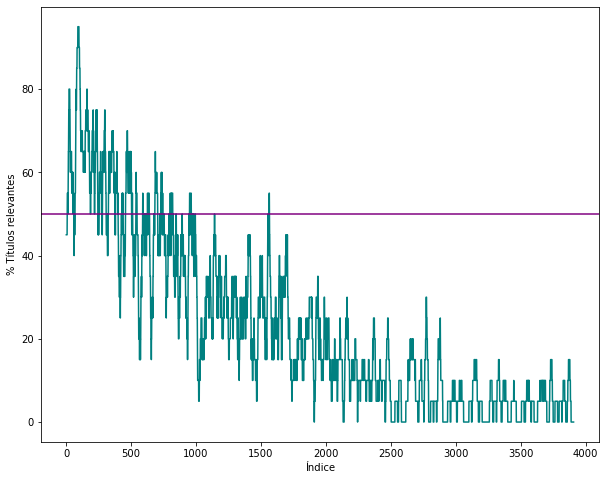

In [27]:
def relevant_title_plot(index_range=20):
    percentages = []
    start_indices = range(ds_jobs.shape[0] - index_range)
    for i in start_indices:
        df_slice = sorted_ds_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)
 
    plt.plot(start_indices, percentages,color='teal')
    plt.axhline(50, c='purple')
    plt.xlabel('Índice')
    plt.ylabel('% Títulos relevantes')
plt.figure(figsize=(10,8))
relevant_title_plot()
plt.show()

Figura 5. Clasificación de los índices de ofertas de empleo en función de la relevancia del título. La relevancia del título es igual al porcentaje de títulos de ciencia de datos en 20 ofertas de empleo consecutivas (empezando en algún índice). Una línea horizontal delimita el 50% de relevancia. La relevancia cae por debajo del 50% a partir de un índice de aproximadamente 550.

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
 def relevant_title_plot(index_range=20):
```
La función ejecuta percent_relevant_titles a través de cada trozo consecutivo de index_range empleos. A continuación, se trazan todos los porcentajes. El parámetro index_range está preestablecido en 20. Más adelante, ajustamos el valor de ese parámetro.

```python
 start_indices = range(ds_jobs.shape[0] - index_range)
```
Analiza sorted_ds_jobs[i: i + index_range], donde $i$ va de 0 al recuento total de envíos menos el rango de índices.

El gráfico fluctúa con un alto grado de varianza. Pero a pesar de las fluctuaciones, podemos observar que los títulos relevantes de la ciencia de datos caen por debajo del 50% a un índice de alrededor de 550. ¿Seguirá existiendo el límite si duplicamos el intervalo del índice? Lo averiguaremos ejecutando relevant_title_plot(index_range=40) (figura 6). También trazamos una línea vertical en el índice 550 para confirmar que el porcentaje cae por debajo del 50% más allá de esa línea.

13. Trazar el porcentaje de relevancia a través de un rango de índice incrementado

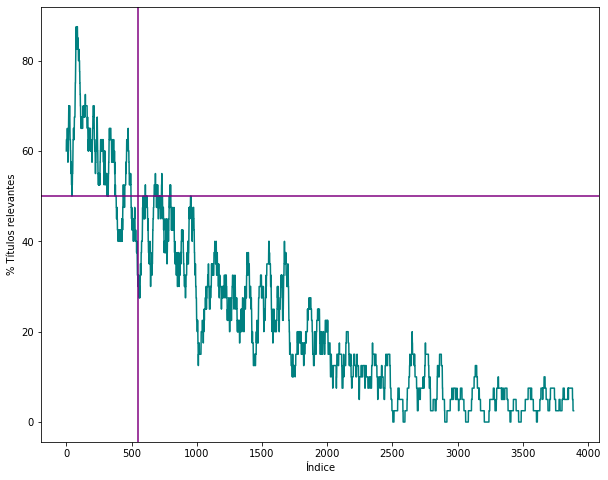

In [28]:
plt.figure(figsize=(10,8))
relevant_title_plot(index_range=40)
plt.axvline(550, c='purple')
#tikzplotlib.save("fig009.tex")
plt.show()

Figura 6. Clasificación de los índices de ofertas de empleo en función de la relevancia del título. La relevancia del título es igual al porcentaje de títulos de ciencias de datos en 40 ofertas de empleo consecutivas (empezando en algún índice). Una línea horizontal marca el 50% de relevancia, y una línea vertical marca un índice de 550. Más allá de esa línea, la relevancia cae a menos del 50%.

Nuestro gráfico actualizado sigue cayendo por debajo del 50% con un índice de corte de 550.

En este punto, tenemos que elegir entre dos límites de relevancia. El primero, con un índice de 98, es muy preciso: la mayoría de las ofertas por debajo de ese índice son de ciencias de datos. Sin embargo, el umbral tiene una capacidad de recuperación limitada: cientos de puestos de ciencias de datos aparecen más allá de un índice de 98. Mientras tanto, nuestro segundo umbral de 550 capta muchos más puestos en ciencia de datos, pero también aparecen algunos empleos irrelevantes por debajo del umbral. Entonces, ¿qué límite elegimos? ¿Preferimos una mayor precisión o una mayor recuperación? Si elegimos una mayor recuperación, ¿perjudicará el ruido a nuestro análisis? Si elegimos una mayor precisión, ¿la limitada diversidad de competencias observadas hará que nuestro análisis sea incompleto? Todas estas preguntas son importantes. Por desgracia, no hay una respuesta correcta inmediata. Una mayor precisión a expensas de la recuperación podría perjudicarnos, y viceversa. ¿Qué debemos hacer?

¿Qué tal si probamos ambos límites? Así podremos comparar las ventajas y desventajas de cada uno. En primer lugar, agruparemos los conjuntos de competencias de las ofertas de empleo por debajo de un índice de 98. A continuación, repetiremos el análisis para las ofertas de empleo por debajo de un índice de 550. Por último, integraremos estos dos análisis diferentes en una única conclusión coherente.

# 3. Agrupación de competencias en las ofertas de empleo relevantes

Nuestro objetivo es agrupar las competencias en las 80 ofertas de empleo más relevantes. Las competencias de cada oferta son diversas y están parcialmente representadas por viñetas. Por tanto, tenemos que elegir:

* Agrupa los 98 textos en sorted_ds_jobs[:98].body_html .

* Agrupa los cientos de viñetas individuales en sorted_ds_jobs[:98].li_body.

La segunda opción es preferible por las siguientes razones:

* Nuestro objetivo declarado es identificar las competencias que faltan. Las viñetas se centran más en las competencias individuales que en el cuerpo heterogéneo de cada puesto.

* Las viñetas cortas son fáciles de imprimir y leer. No ocurre lo mismo con los textos más extensos. Así pues, la agrupación por viñetas nos permite examinar cada agrupación mediante la salida de una muestra del texto de las viñetas agrupadas.

Agruparemos las viñetas extraídas. Empezaremos almacenando sorted_ds_jobs[:98].li_body en una sola lista.

1. Obtener viñetas de los 98 trabajos más relevantes

In [29]:
def get_relevante_li(num_lis):
    total_lis = []
    for lis in sorted_ds_jobs[:num_lis].li_body:
        total_lis.extend(lis)
    return total_lis

In [30]:
ninety_eight_list = get_relevante_li(98)

* Implementar función para eliminar palabras irrelevantes (stop words).

In [31]:
def clean_text(objects):
    stoplist = stopwords.words('english')
    stoplist_custom = ['years','year','e','g','end','non','etc','able',
                       'large','life','ensure','use','strong','key','plus',
                       'leave','like','edge','hive','conduct','apply']
    stoplist.extend(stoplist_custom)
    for i in range(0,len(objects)):
        objects[i] = objects[i].replace('-', '')
        objects[i] = re.sub(r"[^a-zA-Z]"," ", objects[i])
        objects[i] = objects[i].lower()
        objects[i] = [word for word in objects[i].split() if word.lower() not in stoplist]
        objects[i] = ' '.join(objects[i])
    return objects    

* Limpiar lista de los 98 títulos de Data Science.

In [32]:
ninety_eight_list=clean_text(ninety_eight_list)

¿Cuántas viñetas hay en la lista? ¿Hay alguna viñeta duplicada? Podemos comprobarlo cargando ninety_eight_list en una tabla Pandas y aplicando después el método describe .

2. Resumir las estadísticas básicas de las viñetas

In [33]:
df_lis = pd.DataFrame({'li': ninety_eight_list})
print(df_lis.describe())
#print(df_lis.tail().to_latex())
df_lis.tail()

                     li
count              1229
unique             1085
top     bachelor degree
freq                  4


,li
1224,data manipulation proficiency data manipulatio...
1225,machine learning libraries familiarity machine...
1226,probability statistics understanding probabili...
1227,sql knowledge sql querying extracting data dat...
1228,sofware engineering practices understanding fu...


La lista contiene 1229 viñetas. Sin embargo, sólo 1106 son únicas: las 123 restantes son duplicados. El duplicado más frecuente se menciona cuatro veces. Si no solucionamos este problema, podría afectar a nuestra agrupación. Deberíamos eliminar todos los textos duplicados antes de proseguir con nuestro análisis.

A continuación, filtramos las cadenas vacías y los duplicados de nuestra lista de viñetas. A continuación, vectorizamos la lista con un vectorizador TFIDF.

3. Eliminar duplicados y vectorizar las viñetas

In [34]:
ninety_eight_list = sorted(set(ninety_eight_list))
ninety_eight_vectorizer = TfidfVectorizer(stop_words='english')
ninety_eight_matrix = ninety_eight_vectorizer.fit_transform(ninety_eight_list)
num_rows, num_columns = ninety_eight_matrix.shape
print(f"Nuestra matriz tiene {num_rows} filas y {num_columns} columnas")

Nuestra matriz tiene 1085 filas y 2248 columnas


<h4 style='color:purple'>¿Comó funciona?</h4>

```python
 ninety_eight_list = sorted(set(ninety_eight_list))
```
Convierte ninety_eight_list en un conjunto para eliminar los 123 duplicados. Ordenamos ese conjunto para asegurar un orden consistente (y por tanto una salida consistente). Alternativamente, podemos eliminar los duplicados directamente de nuestra tabla Pandas ejecutando df_lis['li'].drop_duplicates(inplace=True).

Hemos vectorizado nuestra lista de viñetas deduplicadas. La matriz TFIDF resultante tiene 1106 filas y 2235 columnas, por lo que contiene 2 471 910 elementos. Esta matriz es demasiado grande para un clustering eficiente. Reduzcamos dimensionalmente la matriz usando la descomposición TruncatedSVD: reduciremos la matriz a 200 dimensiones con SVD, y luego normalizaremos la matriz.

4. Reducir dimensionalmente la matriz TFID

In [35]:
np.random.seed(12)
def shrink_matrix(tfidf_matrix,component):
    svd_object = TruncatedSVD(n_components=component)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)

In [36]:
ninety_eight_norm_matrix = shrink_matrix(ninety_eight_matrix,200)

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
 def shrink_matrix(tfidf_matrix,component):
```
Aplica SVD a una matriz TFIDF de entrada. La matriz se reduce a 100 dimensiones, se normaliza y se devuelve.

Estamos casi listos para agrupar nuestra matriz normalizada utilizando K-means. Sin embargo, primero tenemos que estimar $k$. Vamos a generar un gráfico de codo utilizando K-means (figura 7).

5. Trazado de una curva de codo utilizando K-means

In [94]:
np.random.seed(0)
def elbow_plot(matrix):
    k_values = range(1, 81)
    inertia_values = [KMeans(k).fit(matrix).inertia_
                      for k in k_values]
    plt.figure(figsize=(10,8))
    plt.plot(k_values, inertia_values,c='purple')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    #tikzplotlib.save("fig020.tex")
    plt.show()
    return inertia_values

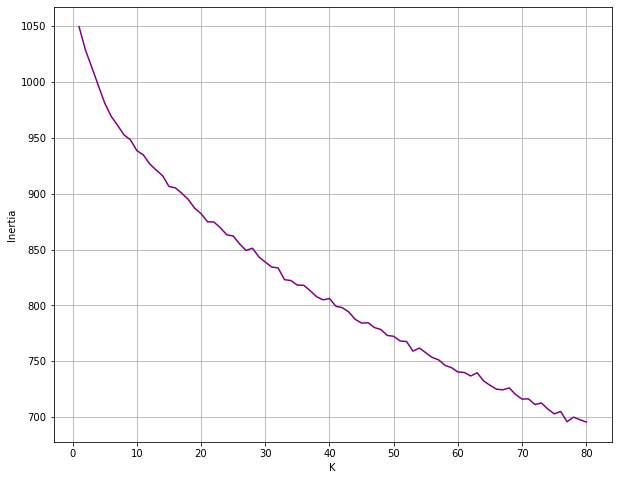

In [40]:
inertia_values=elbow_plot(ninety_eight_norm_matrix)

Figura 7. Gráfico de codo generado mediante K-means, con valores de $k$ comprendidos entre 1 y 80. La ubicación exacta del codo es difícil de determinar.

Nuestra curva trazada disminuye suavemente. La forma de codo es difícil de detectar: la curva desciende rápidamente a un $k \approx 20$ y luego se curva gradualmente en forma de codo en algún punto entre un  $k \approx 22$ y un $k \approx 30$. ¿Qué valor de $k$ debemos elegir? ¿20, 25 o algún valor intermedio, como 20 o 30? Para responder estas cuestiones utilizaremos el método KneeLocator para encontrar dicho punto de inflexión.

6. Encontrar el elbow usando la libreria kneeLocator.

In [42]:
klocator = KneeLocator(range(1, 81), inertia_values, curve="convex", direction="decreasing")
print(f'k={klocator.elbow}')

k=27


## 3.1. Agrupación de las competencias profesionales en 27 grupos

Ejecutamos K-means utilizando un $k=27$. A continuación, almacenamos los índices de texto y los ID del clúster en una tabla Pandas. También almacenamos el texto de las viñetas para facilitar el acceso. Por último, utilizamos el método groupby de Pandas para dividir la tabla por cluster.

1. Agrupar las viñetas en 27 grupos

In [46]:
np.random.seed(12)
def get_cluster(matrix, k, total_list):
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(matrix)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': total_list})
    return [df_cluster for _, df_cluster in df.groupby('Cluster')]

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
 def compute_cluster_groups(matrix, k,total_list):
```
Ejecuta la agrupación K-means en la matriz de entrada matrix. El parámetro K son el número de clusters. La función devuelve una lista de tablas Pandas, donde cada tabla representa un cluster. Las viñetas agrupadas se incluyen en estas tablas; las viñetas se pasan a través de un parámetro opcional de total_list.


```python
 df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': total_list})
```
Rastrea el índice de cada viñeta agrupada en clusters, el ID del cluster y el texto

In [47]:
np.random.seed(12)
cluster_list = get_cluster(ninety_eight_norm_matrix,27, ninety_eight_list)
cluster_list[0].head()

,Index,Cluster,Bullet
31,31,0,advanced degree quantitative field
53,53,0,b computer science related field phd
54,54,0,b computer science statistics machine learning...
55,55,0,bachelor data science computer science enginee...
56,56,0,bachelor degree


In [48]:
#exportat datos a tabla para archivo tex
print(cluster_list[0].head().to_latex())

\begin{tabular}{lrrl}
\toprule
{} &  Index &  Cluster &                                             Bullet \\
\midrule
31 &     31 &        0 &                 advanced degree quantitative field \\
53 &     53 &        0 &               b computer science related field phd \\
54 &     54 &        0 &  b computer science statistics machine learning... \\
55 &     55 &        0 &  bachelor data science computer science enginee... \\
56 &     56 &        0 &                                    bachelor degree \\
\bottomrule
\end{tabular}



Cada uno de nuestros clusters de texto se almacena como una tabla Pandas en la lista cluster_list. Podemos visualizar los clusters usando nubes de palabras.

2. Visualizar el primer cluster

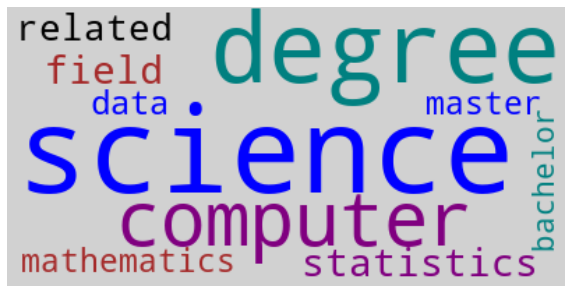

In [49]:
def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])
np.random.seed(12)
text=' '.join(cluster_list[0].Bullet)
vect_text = TfidfVectorizer(stop_words='english')
matrix_text = vect_text.fit_transform([text]).toarray()
df = pd.DataFrame({'palabras': vect_text.get_feature_names(),
                      'suma_tfidf': matrix_text.sum(axis=0)})
df_sort = df.sort_values('suma_tfidf', ascending=False)
freq= dict(zip(df_sort['palabras'], df_sort['suma_tfidf']))
wc = WordCloud(background_color='#d1d1d1',max_words=10,stopwords='english',
               color_func = _color_func).fit_words(freq) 
fig=plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(wc,interpolation='bilinear');

Figura 8. Nube de palabras generada para el cluster de índice 0. El lenguaje de la nube de palabras es alentador. Parece describir una personalidad centrada y orientada a trabajar en Data Science.

El lenguaje de la nube de palabras parece describir a alguien centrado y orientado Machine Learning y Análisis Estadístico. Tal vez podamos aprender más sobre el clúster imprimiendo algunas viñetas de muestra de cluster_list[0]. 

3. Mostrar las viñetas del cluster 0

In [54]:
np.random.seed(12)
def print_cluster_sample(cluster_id):
    df_cluster = cluster_list[cluster_id]
    for bullet in np.random.choice(df_cluster.Bullet.values, 5,replace=False):
        print(bullet)
        
print_cluster_sample(0)        

pursuing ph final discipline related data science statistics mathematics computer science engineering
postgraduate degree higher computer science cheminformatics mathematics related field
bachelor degree experience masters degree experience phd experience
ms phd computer science engineering statistics economics physics related quantitative field econometrics mathematics operations research
master degree quantitative field


Todas las viñetas impresas utilizan un lenguaje muy similar: piden un empleado orientado a Machine Learning. Además, sólidos conocimientos en Análisis Estadístico y Matemática avanzada, estas competencias abstractas no se han estudiado, pero no tenemos porque entender el concepto matemático de los algoritmos sino su correcta aplicacíon.

Examinemos los 25 grupos simultáneamente mediante nubes de palabras. Estas nubes de palabras se muestran en 25 subgrupos en una cuadrícula de seis filas por cuatro columnas (figura 9).

4. Visualizar los 27 clusters

```python
#método alternativo

np.random.seed(12)
def plot_WordCloud(df_cluster,row=5,col=5):
    f=plt.figure(figsize=(20,15))
    for i in range(0,len(df_cluster)):
        fplot=f.add_subplot(row,col,i+1)
        text=' '.join(df_cluster[i].Bullet).lower()
        text = re.sub(r"[^a-zA-Z]"," ",text)
        stoplist = stopwords.words('english')
        stoplist_custom = ['years','e','g','end','non','etc']
        stoplist.extend(stoplist_custom)
        words = [word for word in text.split() if word.lower() not in stoplist]
        freq = Counter(words)
        wc = WordCloud(background_color='#d1d1d1',max_words=10,
                       color_func = _color_func).generate_from_frequencies(freq)
        plt.title(f'Cluster: {df_cluster[i].Cluster.iloc[0]}')
        plt.axis('off')
        plt.imshow(wc,interpolation = "bilinear");
```        

In [124]:
np.random.seed(12)
def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])
def plot_WordCloud2(df_cluster,row=6,col=5):
    f=plt.figure(figsize=(20,18))
    for i in range(0,len(df_cluster)):
        fplot=f.add_subplot(row,col,i+1)
        text=' '.join(df_cluster[i].Bullet)
        vect_text = TfidfVectorizer(stop_words='english')
        matrix_text = vect_text.fit_transform([text]).toarray()
        df = pd.DataFrame({'palabras': vect_text.get_feature_names(),
                           'suma_tfidf': matrix_text.sum(axis=0)})
        df_sort = df.sort_values('suma_tfidf', ascending=False)
        freq= dict(zip(df_sort['palabras'], df_sort['suma_tfidf']))
        wc = WordCloud(background_color='#e1e1e1',max_words=10,stopwords='english',
                       color_func = _color_func).fit_words(freq)
        plt.title(f'Cluster: {df_cluster[i].Cluster.iloc[0]}')
        plt.axis('off')
        plt.imshow(wc,interpolation='bilinear');

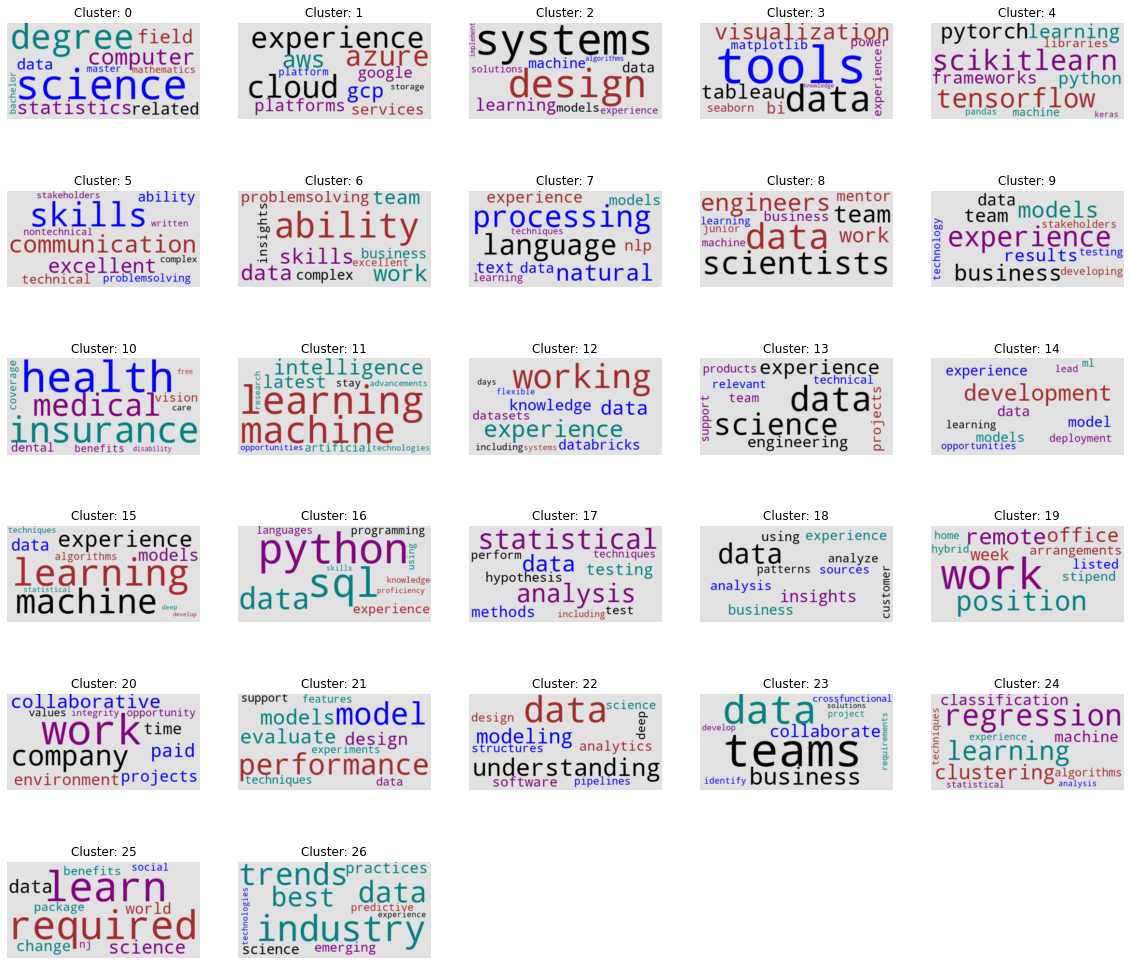

In [125]:
plot_cluster_list=plot_WordCloud2(cluster_list)

Figura 9. 27 nubes de palabras visualizadas en 27 subparcelas. Cada nube de palabras corresponde a uno de los 27 clusters. Los títulos de las subtramas corresponden a los ID de los grupos. Algunos clusters, como el 24, describen habilidades técnicas; otros, como el 5, son menos técnicos.

Los 27 grupos de competencias muestran una variada colección de temas. Algunos de los grupos son muy técnicos. Por ejemplo, el grupo 24 se centra en Machine Learning, algoritmos de regresión, clasificaión y clustering. La mayoría de estos temas se han estudiado en este curso. Imprimamos una muestra de viñetas del clúster 24 y confirmemos su enfoque en bibliotecas de ciencia de datos.

5. Mostrar la viñetas del cluster 24

In [55]:
np.random.seed(12)
print_cluster_sample(24)

experience implementing statistical machine learning methods data classification regression
experience mixed effects regression clustering outlier detection survival analysis modeling
expertise statistical machine learning techniques including regression clustering classification algorithms
understanding machine learning techniques clustering classification regression
machine learning experience machine learning algorithms regression classification clustering gradient boosting


Otros grupos, como el grupo 5, se centran en las competencias no técnicas. Estas habilidades blandas, que se centran en la colaboración, comunicación verbal, faltan claramente en nuestra tabla de contenidos. Por tanto, de media, los grupos no técnicos deberían tener una menor similitud con la tabla de contenidos. Esta línea de pensamiento nos lleva a una posibilidad interesante: tal vez podamos separar los grupos técnicos y los grupos no técnicos utilizando la similitud textual. La separación nos permitiría examinar más sistemáticamente cada tipo de habilidad. Empezaremos calculando la similitud coseno entre cada viñeta de ninety_eight_list y nuestra tabla de contenidos del curso.

6. Calcular similitudes entre las viñetas y nuestro contenido del curso

In [126]:
def compute_bullet_similarity(bullet_texts):
    bullet_vectorizer = TfidfVectorizer(stop_words='english')
    matrix = bullet_vectorizer.fit_transform(bullet_texts + [skills])
    matrix = matrix.toarray()
    return matrix[:-1] @ matrix[-1]

In [127]:
bullet_cosine_similarities = compute_bullet_similarity(ninety_eight_list)

<h4 style='color:purple'>¿Comó funciona?</h4>

```python
    def compute_bullet_similarity(bullet_texts):
```

Calcula las similitudes del coseno entre los **bullet_texts** introducidos y la variable **resume**.

7. Comparar las similitudes de los contenidos promedio

In [128]:
def compute_mean_similarity(df_cluster):
    indices = df_cluster.Index.values
    return bullet_cosine_similarities[indices].mean()

In [129]:
tech_mean = compute_mean_similarity(cluster_list[24])
soft_mean = compute_mean_similarity(cluster_list[5])
print(f"El cluster técnico 24 tiene una similitud media de {tech_mean:.3f}")
print(f"El clúster no técnico 5 tiene una similitud media de {soft_mean:.3f}")

El cluster técnico 24 tiene una similitud media de 0.179
El clúster no técnico 5 tiene una similitud media de 0.002


El cluster técnico está 90 veces más cerca de nuestra tabla de contenidos que el clúster de competencias no técnicas. Parece que vamos por buen camino. Calculemos la similitud media de los 27 grupos. A continuación, ordenaremos los clusters por su puntuación de similitud, en orden descendente. Si nuestra hipótesis es correcta, los clusters técnicos aparecerán en primer lugar en los resultados ordenados.

8. Ordenar subparcelas por similitud de contenido

In [130]:
def sort_cluster_groups(cluster_groups):
    mean_similarities = [compute_mean_similarity(df_cluster)
                         for df_cluster in cluster_groups]
 
    sorted_indices = sorted(range(len(cluster_groups)),
                            key=lambda i: mean_similarities[i],
                            reverse=True)
    return [cluster_groups[i] for i in sorted_indices]

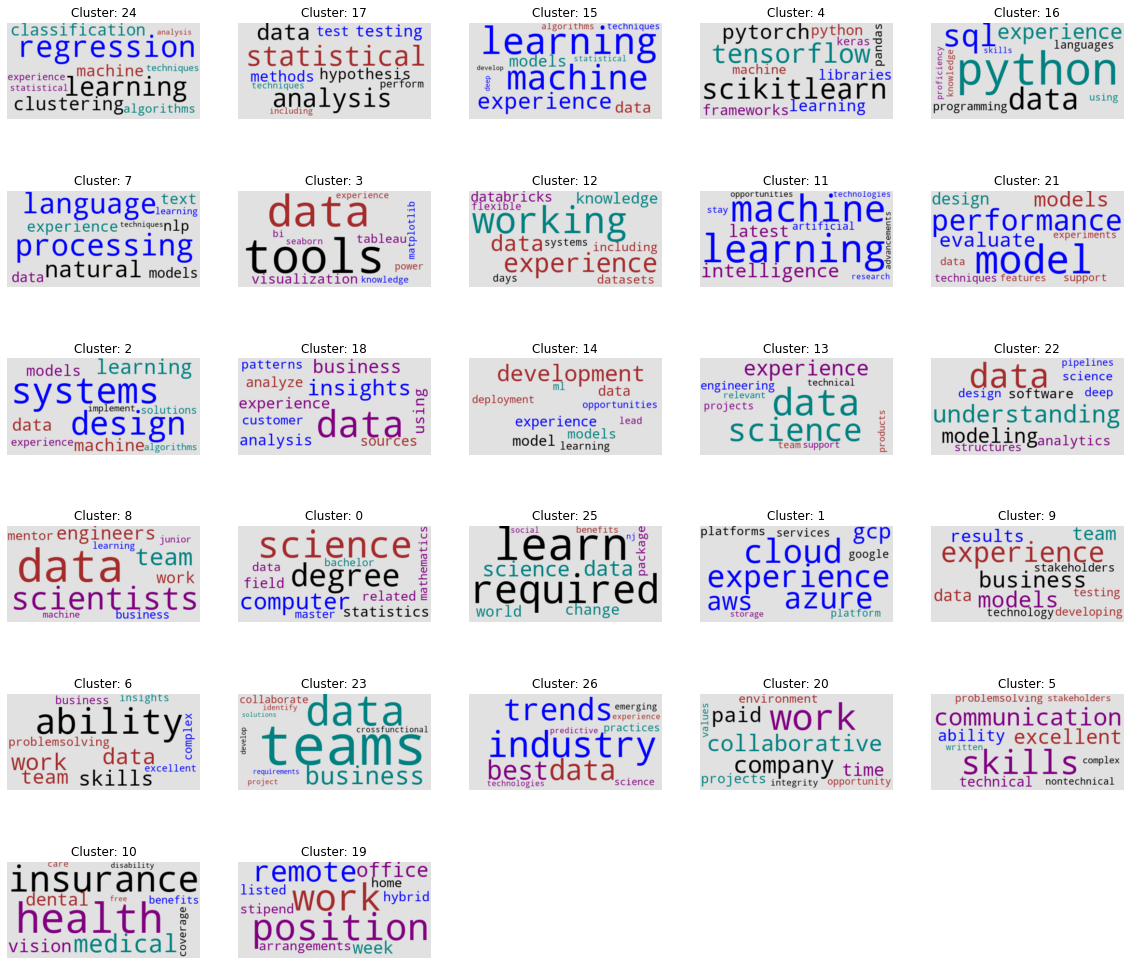

In [132]:
sorted_cluster_groups = sort_cluster_groups(cluster_list)
plot_sorted_cluster_groups=plot_WordCloud2(sorted_cluster_groups)

Figura 10. 27 nubes de palabras visualizadas en 27 subparcelas. Cada nube de palabras corresponde a uno de los 27 grupos. Los grupos están ordenados por la similitud media de la tabla de contenidos. Las dos primeras filas de la cuadrícula de subparcelas corresponden a grupos más técnicos.

Nuestra hipótesis era correcta. Las dos primeras filas del subgrupo actualizado corresponden claramente a competencias técnicas. Además, estas competencias técnicas están ahora convenientemente ordenadas en función de su similitud con nuestra tabla de contenidos. Esto nos permite clasificar sistemáticamente las competencias desde las más parecidas (y, por tanto, representadas en nuestra tabla de contenidos) a las menos parecidas (y, por tanto, susceptibles de faltar en nuestra tabla de contenidos).

## 3.2. Investigación de los grupos de competencias técnicas

Centrémonos en los 10 grupos de competencias técnicas de las dos primeras filas de los 25 grupos. A continuación, volvemos a representar sus nubes de palabras asociadas en una cuadrícula de cinco filas por dos columnas (figura 11). Esta visualización técnicamente enfocada nos permitirá ampliar el tamaño de la nube de palabras. Más adelante, volveremos a las restantes nubes de palabras de competencias no técnicas de la figura 10.

1. Trazar los diez primeros clusters técnicos

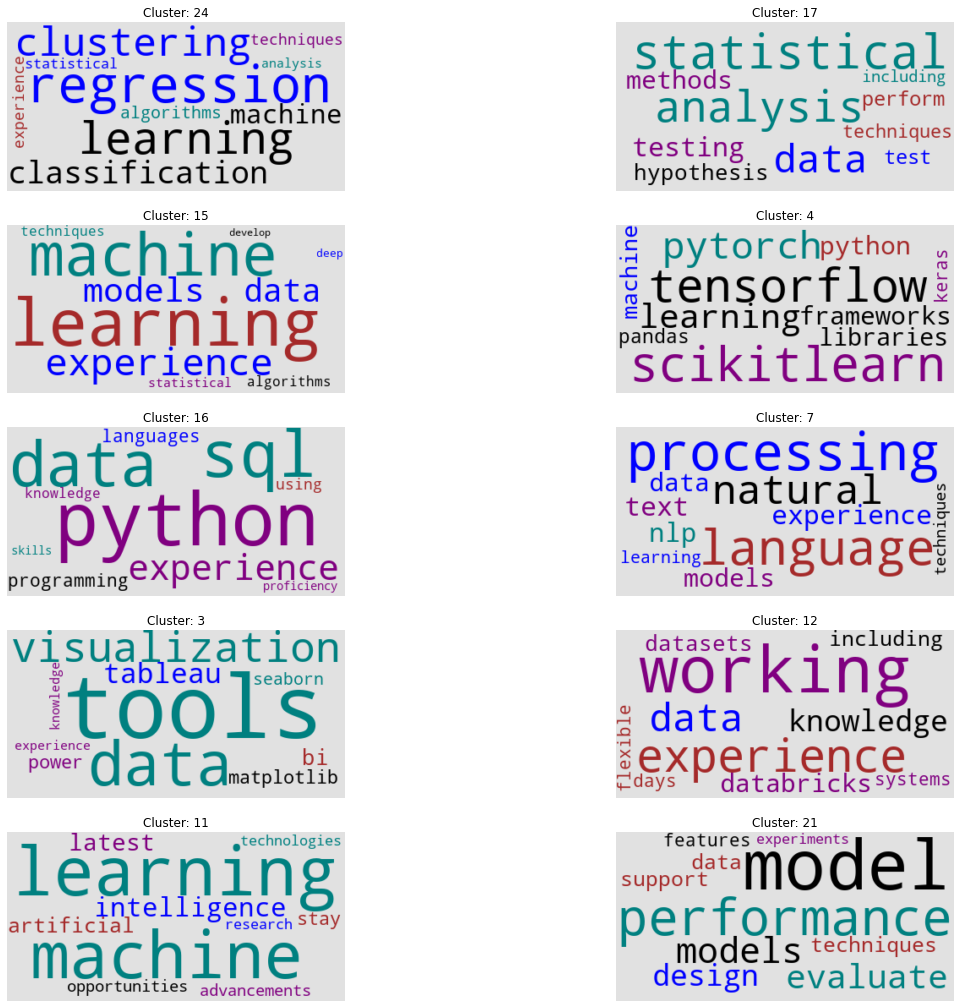

In [145]:
plot_sort_six=plot_WordCloud2(sorted_cluster_groups[:10],row=5,col=2);

Figura 11. Diez nubes de palabras asociadas a diez grupos de competencias técnicas. Están ordenadas por la similitud media de la tabla de contenidos. Las siete primeras nubes de palabras son informativas: se centran en bibliotecas de ciencia de datos, análisis estadístico, programación en Python, SQL y NPL (natutal language processing). Las tres restantes son vagas y poco informativas.

Los siete primeros grupos de competencias técnicas de la cuadrícula son muy informativos. Vamos a examinarlos uno por uno, empezando por el cuadrante superior izquierdo. En aras de la brevedad, nos basaremos únicamente en las nubes de palabra.

Los siete primeros grupos técnicos pueden describirse del siguiente modo:

* Cluster 24 (fila 0, columna 0): Se centra en machine learning (algoritmos de regresión, clasificación y clustering). Por otra parte, Deep Learning no se ha discutido en el nuestro curso. 

* Cluster 17 (fila 0, columna 1): Análisis estadístico, test de hipótesis

* Cluster 15 (fila 1, columna 0): Se centa en estadística y machine learning. 

* Cluster 4 (fila 1, columna 1): Librerías como scikit-learn, pandas ya ha sido discutidas. Los únicos frameworks del cual carecemos de estudio es TensorFlow, Keras y Pytorch. Se trata de librerías de aprendizaje profundo utilizadas por los profesionales de la IA para entrenar modelos predictivos complejos en hardware de alta potencia.
  
* Cluster 16 (fila 2, columna 0): Este grupo se centra en la eficacia de los lenguajes de programación. Entre los lenguajes, Python y Sql predominan claramente. Esto se debe a que en muestra tabla de contenidos hacemos referencia a muchas librerías de Python, lo que implica nuestra familiaridad con el lenguaje. 

* Cluster 7 (fila 2, columna 1): Este grupo se centra principalmente en el análisis y procesamiento de textos (NPL).

* Cluster 3 (fila 3, columna 0): Este grupo se centra en la vizualización de datos con matplotlib, seaborn. También have mencion a Tableau y PowerBi.

El último grupo de competencias técnicas es vago y poco informativo. Mencionan numerosas herramientas y técnicas de análisis no relacionadas.

2. Mostrar las viñetas de los clusters 22 y 11

In [105]:
for cluster_id in [22, 11]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 22:
perform feature engineering modeling multimodal data produce high quality modular reusable code incorporates coding best practices serves example broader data science community within organization
understanding modern ide eclipse intellij idea netbeans
financial risk analytics data science predictive modeling work experience
role integral maintaining improving email personalization models pipelines addition modeling engagement content affinity
leverage deep understanding retail sector identify business challenges opportunities datadriven solutions specifically focused customer data

Cluster 11:
keen interest learning new technologies staying updated latest research trends
leverage machine learning artificial intelligence increase insight trend analysis
build maintain machine learning models enhance emotional intelligence capabilities company products
stay updated latest developments ai emotional intelligence nlp
applies artificial intelligence machine learning techniques s

Hemos terminado el análisis de los grupos de competencias técnicas. Siete de estos grupos eran relevantes y tres no lo eran. Ahora vamos a centrarnos en los grupos de competencias no técnicas. Queremos ver si hay algún grupo de competencias no técnicas relevante en los datos.

## 3.3. Investigación de los grupos de competencias no técnicas

Empezaremos visualizando los 17 grupos de competencias no técnicas restantes en una cuadrícula de cinco filas por tres columnas (figura 12).

1. Graficar los 17 clusters restantes

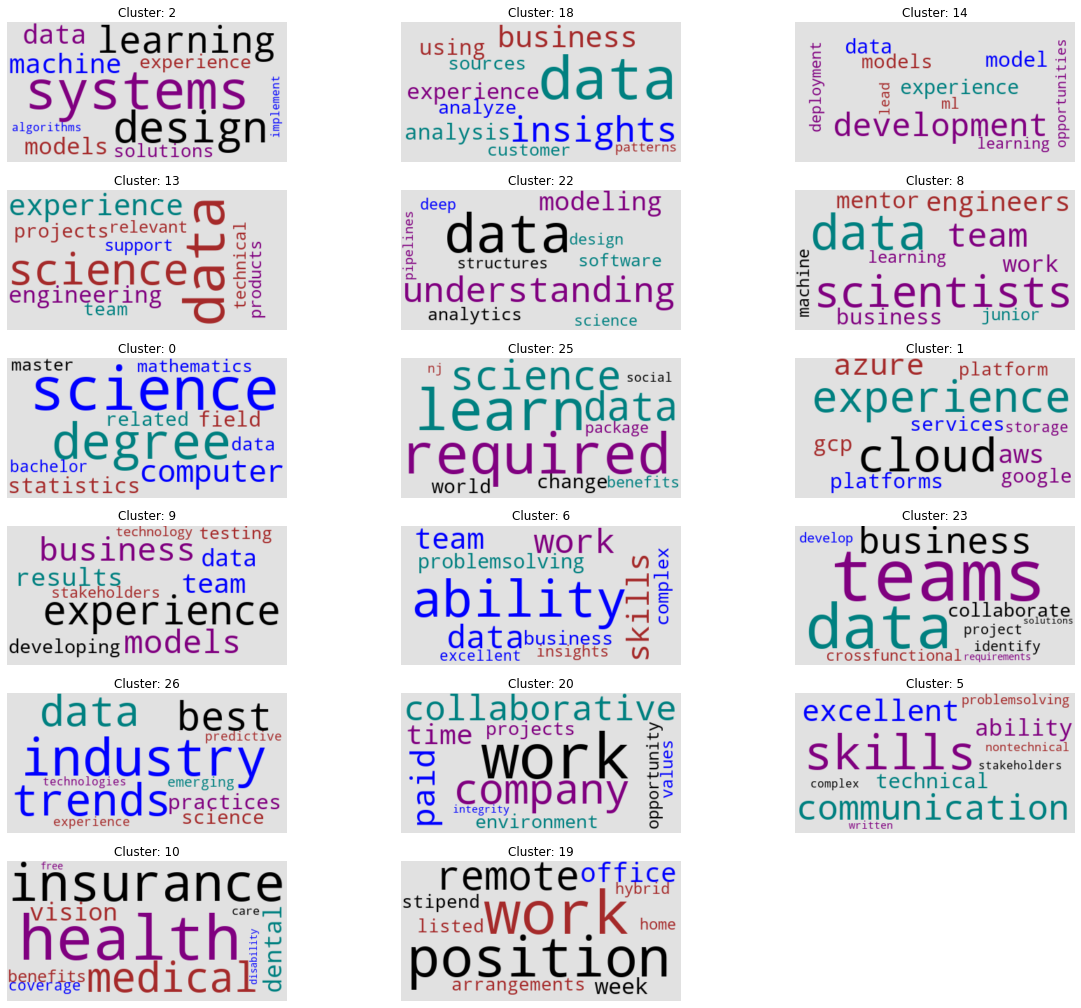

In [146]:
plot_WordCloud2(sorted_cluster_groups[10:], row=6, col=3)
plt.show()

Figura 12. Nubes de palabras asociadas a quince grupos de competencias no técnicas. Están ordenadas por la similitud media de la tablas de contenios.

Estos 15 grupos parecen mucho más ambiguos que los siete primeros grupos técnicos. Son más difíciles de interpretar. Por ejemplo, el grupo 6 (fila 3, columna 1) utiliza términos vagos como trabajo y equipo. El cluster 19 (fila 5, columna 1) es igualmente enigmático, compuesto por términos como etrabajo, remoto y posición. Además, el resultado se complica con agrupaciones que no representan verdaderas competencias. Por ejemplo, el grupo 10 (fila 5, columna 0) no está compuesto por competencias de  Data Science, sino por: beneficios, visión, dental, etc. Nos equivocamos ligeramente en nuestras suposiciones: no todas las viñetas representan verdaderas competencias. Podemos confirmar nuestro error mostrando las viñetas de los grupos 10 y 19.

2. Mostrar las viñetas los clusters 10 y 19

In [107]:
for cluster_id in [10, 19]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 10:
additional options dental vision benefits disability coverage flexible spending accounts supplemental health protection plans accident critical illness hospital indemnity auto home insurance identity theft protection legal counseling longterm care coverage moving assistance pet insurance
disability insurance
covered health vision dental insurance
health insurance medical dental vision
health wellness benefits package

Cluster 19:
fulltime oncampus position days remote work per week possibility
relocation jacksonville florida metro area desired although position remote
flexible work arrangements including remote work options
position listed onsite work colleagues clients person needed specific role
hybrid work arrangements


Uno de nuestros clusters de habilidades interpersonales es muy fácil de interpretar: el cluster 19 (fila 4, columna 2) se centra en las habilidades de comunicación interpersonal, tanto escritas como verbales. Unas buenas habilidades de comunicación son cruciales en una carrera de ciencia de datos. Las ideas que extraemos de datos complejos deben comunicarse cuidadosamente a todas las partes interesadas. Las partes interesadas tomarán medidas en función de la persuasión de nuestros argumentos. Si no somos capaces de comunicar nuestros resultados, todo nuestro esfuerzo quedará en nada.

Las habilidades de comunicación no son fáciles de aprender, se requiere la colaboración práctica con otras personas. Si desea ampliar sus habilidades de comunicación, debería considerar la posibilidad de interactuar con otros científicos de datos, ya sea a nivel local o a distancia. Puede elegir un proyecto basado en datos y compartitlo en equipo (una plataforma muy eficiente de interactuar sería GitHub). 

## 3.5. Analizar las 550 publicaciones más relevantes
Comenzamos preparando sorted_ds_jobs[:550].li_body para la agrupación haciendo lo siguiente:

* Extraer todas las viñetas eliminando las duplicadas.
* Vectorizar los textos de las viñetas.
* Reducir dimensionalmente los textos vectorizados y normalizar la matriz resultante.

1. Preparar de sorted_ds_jobs[:550].li_body para el análisis de los clusters

In [138]:
lists_550=get_relevante_li(550)

In [139]:
lists_550=clean_text(lists_550)

In [140]:
lists_550 = sorted(set(lists_550))
vectorizer_550 = TfidfVectorizer(stop_words='english')
matrix_550 = vectorizer_550.fit_transform(lists_550)
num_rows, num_columns = matrix_550.shape
print(f"Nuestra matriz tiene {num_rows} filas y {num_columns} columnas")

Nuestra matriz tiene 6660 filas y 6122 columnas


2. Reducir dimensionalmente la matriz TFID

In [141]:
np.random.seed(12)
norm_matrix_550 = shrink_matrix(matrix_550,200)

Hemos vectorizado 6810 viñetas. Ahora generamos un gráfico de codo con los resultados vectorizados. Basándonos en observaciones anteriores, no esperamos que el gráfico de codo sea especialmente informativo, pero lo creamos para mantener la coherencia con nuestros análisis anteriores (figura 16).

3. Graficar una curva de codo para las 6660 viñetas

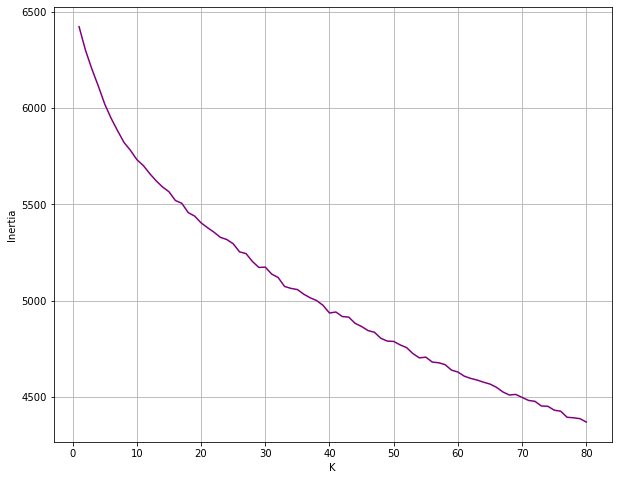

In [95]:
np.random.seed(0)
inertia_values_550=elbow_plot(norm_matrix_550)

Figura 16. Gráfico de codo generado a partir de las viñetas de los 550 mensajes más relevantes. La ubicación exacta del codo es difícil de determinar.

Como era de esperar, la ubicación precisa del codo no está clara en el gráfico. Trataremos la ambigüedad con la ayuda del método kneeLocator para encontrar el $k$.

In [112]:
klocator_550 = KneeLocator(range(1, 81), inertia_values_550, curve="convex", direction="decreasing")
print(f'k_550={klocator_550.elbow}')

k_550=29


4. Agrupar las viñetas en 29 grupos

In [113]:
np.random.seed(12)
cluster_list_550 = get_cluster(norm_matrix_550,29, lists_550)
cluster_list_550[0].head()

,Index,Cluster,Bullet
0,0,0,
2,2,0,ability absorb amounts information prioritize ...
8,8,0,ability analyze information identify secondord...
9,9,0,ability analyze synthesize
10,10,0,ability anticipate changes impacts


In [82]:
#exportat datos a tabla para archivo tex
print(cluster_list_550[0].head().to_latex())

\begin{tabular}{lrrl}
\toprule
{} &  Index &  Cluster &                                             Bullet \\
\midrule
0  &      0 &        0 &                                                    \\
2  &      2 &        0 &  ability absorb amounts information prioritize ... \\
8  &      8 &        0 &  ability analyze information identify secondord... \\
9  &      9 &        0 &                         ability analyze synthesize \\
10 &     10 &        0 &                 ability anticipate changes impacts \\
\bottomrule
\end{tabular}



5. Visualización de 29 clusters ordenados.

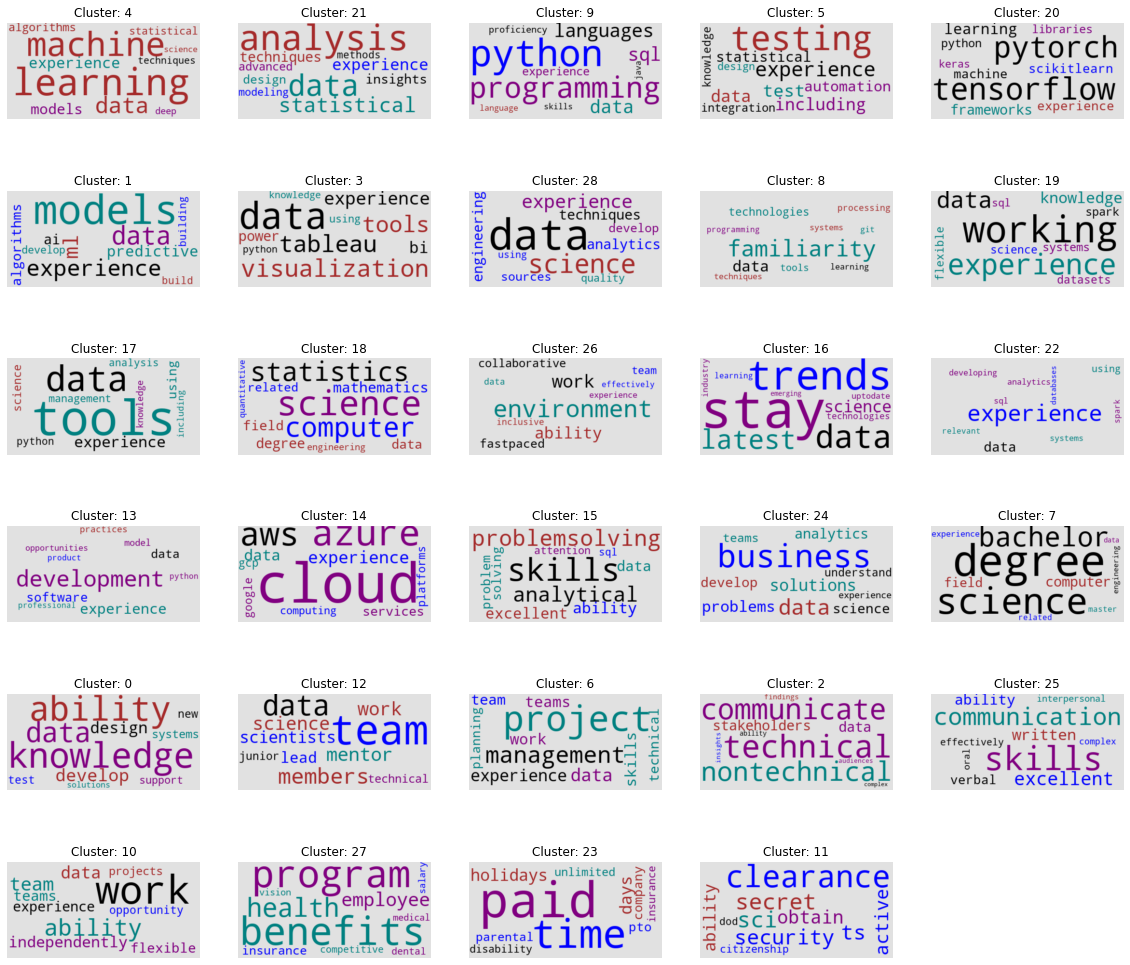

In [142]:
bullet_cosine_similarities = compute_bullet_similarity(lists_550)
sorted_cluster_groups_550 = sort_cluster_groups(cluster_list_550)
plot_WordCloud2(sorted_cluster_groups_550, row=6, col=5)
plt.show()

Figura 17. 29 nubes de palabras generadas agrupando más de 6660 viñetas. A pesar de que el número de viñetas se ha multiplicado por 6 los grupos de competencias observados siguen siendo casi los mismos.

El resultado de la agrupación es muy similar al que hemos visto antes. Se mantienen las agrupaciones clave que observamos en las 98 listas que vimos antes, incluido el uso de bibliotecas de ciencias de datos (fila 0, columna 0), análisis estadístico (fila 0, columna 1), programación en Python (fila 0, columna 2) y habilidades de comunicación (fila 7, columna 1). Hay algunos cambios sutiles, pero en su mayor parte, el resultado es el mismo. 

# 4. Conclusión

En primer lugar, deberíamos destacar nuestros conocimientos de Python. Una sola línea que diga que dominamos Python debería ser suficiente. Además, queremos hacer valer nuestras habilidades comunicativas. ¿Cómo demostramos que somos buenos comunicadores? Es complicado; no basta con decir que podemos comunicar con claridad resultados complejos a diferentes audiencias. En su lugar, debemos describir un proyecto personal en el que hayamos hecho lo siguiente:

1. Colaboración con compañeros de equipo en un problema de datos difícil. 
2. Transmitir resultados complejos, de forma oral o escrita, a un público no técnico.

Si tiene experiencia en este tipo de proyectos, debería ser suficiente. De lo contrario, le animamos a que realice este tipo de proyectos voluntariamente. Los conocimientos que adquirirá serán muy valiosos y mejorarán sus perspectivas de empleo.

Además, tenemos que abordar nuestras deficiencias de habilidades restantes. La experiencia en aprendizaje automático es crucial para una carrera exitosa en la ciencia de datos. Aún no hemos estudiado el aprendizaje automático, pero en el caso práctico siguiente, ampliaremos nuestras habilidades de aprendizaje automático. Entonces podremos describir con orgullo nuestras habilidades de aprendizaje automático en nuestro curso.

Por último, merece la pena demostrar cierta experiencia con herramientas para obtener y almacenar datos remotos. Estas herramientas incluyen bases de datos y servicios alojamiento web. Su uso está fuera del alcance del contenido del curso, pero pueden aprenderse mediante el estudio independiente. La experiencia en bases de datos y servicios web no siempre es necesaria para conseguir un trabajo; sin embargo, los posibles empleadores siempre agradecerán una experiencia limitada.

## Habilidades que faltan

* Almacenar las viñetas de la 98 ofertas de empleo más relevantes en una lista

In [84]:
missing_skills=ninety_eight_list

* Convertir la lsita en una matriz de características TF-IDF y luego crear un dataframe con la suma total de cada palabra

In [85]:
vect_text = TfidfVectorizer(stop_words='english')
matrix_text = vect_text.fit_transform(missing_skills).toarray()
df_rank = pd.DataFrame({'palabras': vect_text.get_feature_names(),
                   'suma': matrix_text.sum(axis=0)})

* Crear una lista cuyos elementos son laa habilidades que nos faltan (habilidades obtenidas en los diferentes clusters)

In [86]:
my_list = ['tableau', 'tensorflow','pytorch','databricks','spark','azure','aws','powerbi']

* Crear un data frame con estas palabras

In [87]:
results = df_rank.loc[df_rank["palabras"].isin(my_list)]

* Agrupar y luego graficar

In [88]:
df=results.groupby(['palabras']).sum()

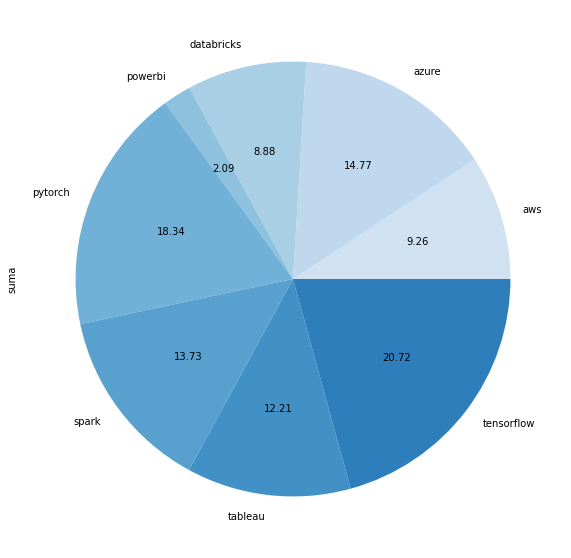

In [93]:
mycolors = plt.get_cmap('Blues')(np.linspace(0.2,0.7, len(df['suma'])))
df['suma'].plot.pie(figsize=(10,10),autopct='%.2f',colors= mycolors)
#tikzplotlib.save("fig018.tex")
plt.show()

# 5. Resumen

1. Los datos de texto no deben analizarse a ciegas. Siempre hay que muestrear y leer parte del texto antes de ejecutar cualquier algoritmo. Esto es especialmente cierto en el caso de los archivos HTML, donde las etiquetas pueden delimitar señales únicas en el texto. Al analizar una muestra de ofertas de empleo, descubrimos que en cada archivo HTML se marcan con viñetas las competencias laborales únicas. Si hubiéramos agrupado ciegamente el cuerpo de cada archivo, nuestros resultados finales no habrían sido tan informativos.

2. Agrupar textos es difícil. Rara vez existe un recuento de grupos ideal, porque el lenguaje es fluido y también lo son las fronteras entre temas. Pero a pesar de la incertidumbre, algunos temas aparecen sistemáticamente en varios recuentos de grupos. Así que, aunque nuestro gráfico de codo no revele el número exacto de grupos, la situación es salvable: el muestreo sobre múltiples parámetros de agrupación puede revelar temas estables en el texto.

3. Elegir los valores de los parámetros no siempre es fácil. Este problema va mucho más allá de la mera agrupación. A la hora de seleccionar nuestro límite de relevancia, nos debatimos entre dos valores: 98 y 550. Ninguno de los dos valores parecía muy superior al otro, así que probamos los dos. En la ciencia de datos, algunos problemas no tienen un umbral o parámetro ideal. Sin embargo, no debemos rendirnos e ignorar esos problemas. Al contrario, debemos experimentar. Los científicos aprenden explorando los resultados de una serie de parámetros de entrada. Como científicos de datos, podemos obtener información muy valiosa modificando y ajustando nuestros parámetros.